In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = "../data"
TICKERS = ["SPY", "QQQ", "IWM"]
FEATURE_PREFIX = "features_"
FEATURE_COLUMNS = [
    "daily_return",
    "rolling_vol_5",
    "sma_10",
    "sma_20",
    "rsi_14",
    "momentum_10",
    "ret_1",
    "price_above_sma_10",
    "bb_width"
]

TARGET_COLUMN = "target"

In [3]:
frames= []

for ticker in TICKERS:
    path = os.path.join(DATA_DIR, f"{FEATURE_PREFIX}{ticker}.parquet")
    df = pd.read_parquet(path)
    df["ticker"] = ticker
    frames.append(df)

# Detect the date-like column first
date_col = next((col for col in frames[0].columns if col.lower().startswith("date")), None)
if date_col is None:
    raise KeyError(f"Could not find date column in {frames[0].columns.tolist()}")

data = pd.concat(frames).sort_values(date_col).reset_index(drop=True)

print(f"✅ Combined dataset shape: {data.shape}")


✅ Combined dataset shape: (7830, 27)


In [4]:
X = data[FEATURE_COLUMNS]
y = data[TARGET_COLUMN]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False  # no shuffle for time series
)
print(f"📊 Train size: {len(X_train)} | Test size: {len(X_test)}")

📊 Train size: 5481 | Test size: 2349


In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("✅ Model trained.")

✅ Model trained.


In [7]:
# Predict probabilities
probs = model.predict_proba(X_test)[:, 1]

# Filter: only predict if confidence is high
threshold = 0.6
confident_preds = (probs > threshold).astype(int)

print(f"🔍 Predictions made with confidence > {threshold}: {(probs > threshold).sum()} of {len(probs)}")

from sklearn.metrics import classification_report
print(classification_report(y_test, confident_preds, target_names=["Down", "Up"]))


🔍 Predictions made with confidence > 0.6: 467 of 2349
              precision    recall  f1-score   support

        Down       0.46      0.79      0.58      1096
          Up       0.50      0.19      0.27      1253

    accuracy                           0.47      2349
   macro avg       0.48      0.49      0.42      2349
weighted avg       0.48      0.47      0.41      2349



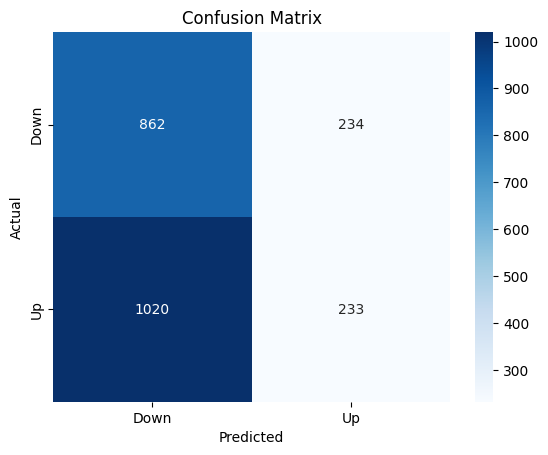

In [15]:
cm = confusion_matrix(y_test, confident_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
joblib.dump(model, os.path.join(DATA_DIR, "rf_model.pkl"))
print("💾 Model saved to data/rf_model.pkl")

💾 Model saved to data/rf_model.pkl
